# Nhập môn khoa học dữ liệu: Project 03 - Fake news detection

Link demo: https://share.streamlit.io/thanhtruong1712/fake-news-detection/streamlit.py

Tiến độ hoàn thành của Project : 100%

## Danh sách thành viên trong nhóm
| MSSV        | Họ và tên          | 
| ----------- | -----------------  | 
| 1712770     | Trương Thị Lệ Thanh|
| 1712771     | Bùi Thái Tấn Thành | 

## Bảng phân công công việc
| Công việc | Thành viên phụ trách | Mức độ hoàn thành | 
| --------| -----------------  | ---------------------|
| Tiền xử lý văn bản tiếng Việt | Thanh & Thành | 100% |
| EDA (khám phá dữ liệu) | Thanh & Thành | 100% |
| Mô hình hóa | Thanh & Thành | 100% |
| Deploy mô hình | Thanh & Thành | 100% |


# I. Dữ liệu

## Thông tin dữ liệu

#### Nguồn dữ liệu: VNFD Dataset

- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật)

# II. Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import sklearn
import pickle
import tensorflow
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

2022-01-09 16:18:17.743632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-09 16:18:17.743701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/thanhtruong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# III. Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

In [2]:
df = pd.read_csv('vn_news_223_tdlfr.csv')
df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

In [3]:
rows, columns = df.shape
print("Dữ liệu có {} dòng và {} cột".format(rows, columns))

Dữ liệu có 223 dòng và 3 cột


## 1.  Tiền xử lý văn bản tiếng Việt

### Các bước tiền xử lý văn bản cơ bản gồm: 
- Lowercase
- Loại stopwords
- Tokenizer
- Stemming
- Loại noise
- Loại dấu câu

Nguồn tham khảo stopword: https://www.kaggle.com/mpwolke/vietnamese-stopwords-w2v

#### Đọc dữ liệu stopwords từ file txt

- Link file txt của stopword: https://www.kaggle.com/mpwolke/vietnamese-stopwords-w2v/data?select=vietnamese.txt

In [4]:
def get_stopword_list(filename):
    with open(filename,'r',encoding='utf-8') as f:
        stopwords=f.readlines()
        stopset=set(m.strip() for m in stopwords)
        return list(frozenset(stopset))
stopwords=set(get_stopword_list('vietnamese.txt'))

In [5]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
wordnet = WordNetLemmatizer()

#### Hàm tiền xử lý văn bản tiếng Việt

In [6]:
def preprocessing_basic(text):
    text = re.sub(r'http\S+','', text)  #Loại noise(xóa link)
    text = re.sub("\\W", ' ', text)     # Xóa khoảng trắng thừa
    #Loại tokenizer và dấu câu
    token_doc = word_tokenize(text)
    result_token = []
    for i in token_doc:
        new_token = regex.sub(u'',i)
        if not new_token == u'':
            result_token.append(new_token)
    #Loại stopwords
    result_stopwords = []
    for text in result_token:
        tmp = text.split(' ')
        for i in tmp:
            if not i in stopwords :
                result_stopwords.append(i)
    #Xử lý stemming và lemmatizion
    final_doc = []
    for i in result_stopwords:
        final_doc.append(wordnet.lemmatize(i))
    return ' '.join(final_doc).lower()

In [7]:
tqdm.pandas()
df.text = df.text.progress_map(preprocessing_basic)
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:04<00:00, 45.77it/s]


,text,domain,label
0,thủ tướng abe cúi đầu lỗi hành động phi thể th...,binhluan.biz,1
1,thủ tướng nhật cúi đầu lỗi tinh thần phi thể t...,www.ipick.vn,1
2,choáng cơ trưởng đeo khăn quàng quẩy banh sân ...,tintucqpvn.net,1
3,chưa bao nhạc kpop hát giáo sư nguyễn lân dũng...,tintucqpvn.net,1
4,đại học hutech áp dụng cải tiếq việt học 2018 ...,www.gioitreviet.net,1


## 2. EDA (Khám phá dữ liệu)

#### Thông tin dữ liệu:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    223 non-null    object
 1   domain  223 non-null    object
 2   label   223 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


Ta thấy dữ liệu không bị thiếu, kiểu dữ liệu không sai

#### Kiểm tra các dòng có bị lặp không?

In [9]:
print('Số dòng dữ liệu bị lặp: ',df.index.duplicated().sum())

Số dòng dữ liệu bị lặp:  0


#### Kiểm tra phân bố các class có chênh lệch không?

In [10]:
df['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

#### Các thông tin thống kê của văn bản 

In [11]:
record_len = df.text.str.len()
print("Chiều dài trung bình của mỗi record: ",(record_len.sum()/len(record_len)).round(3))

Chiều dài trung bình của mỗi record:  1491.812


# IV. Mô hình hóa dữ liệu

In [12]:
#Hàm vẽ ma trận
def plot_matrix(classifier,X_test,Y_test):
    class_name=df.label.value_counts()
    np.set_printoptions(precision=2)
    titles_options=[("confusion matrix,without normalization",None),
                    ("normalized confusion matrix",None)]
    for title,normalize in titles_options:
        disp=plot_confusion_matrix(classifier,X_test,Y_test,display_labels=class_name,
                                   cmap=plt.cm.Blues,normalize=normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)

        
def upload_classifier(classifier):
    X_train,X_test,Y_train,Y_test=train_test_split(df.text,df.label,
                                                   test_size=0.25,random_state=2020)
    pipe=Pipeline([('vect',CountVectorizer()),
                   ('tfidf',TfidfTransformer()),('model',classifier)])
    model=pipe.fit(X_train,Y_train)
    prediction=model.predict(X_test)
    prob=model.predict_proba(X_test)
    plot_matrix(classifier=model,X_test=X_test,Y_test=Y_test)
    return model,prob,Y_test

def generate_roc_curve(model,Y_test,prob,title):
    pred=prob[:,1]
    fpr,tpr,threshold=roc_curve(Y_test,pred)
    roc_auc=auc(fpr,tpr)
    plt.title('{}'.format(title))
    plt.plot(fpr,tpr,'b',label='auc=%0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Logistic Regression

confusion matrix,without normalization
[[26  1]
 [10 19]]
normalized confusion matrix
[[26  1]
 [10 19]]


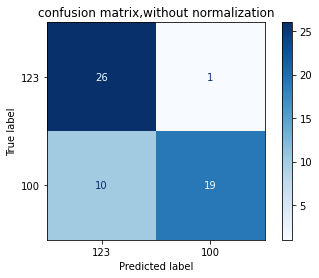

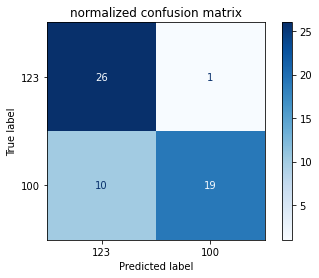

In [13]:
LR_model,prob,Y_test=upload_classifier(classifier=LogisticRegression())

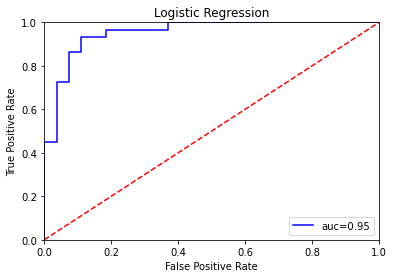

In [14]:
generate_roc_curve(model=LR_model,Y_test=Y_test,prob=prob,title='Logistic Regression')

## Gradient Boost Classifier

confusion matrix,without normalization
[[22  5]
 [12 17]]
normalized confusion matrix
[[22  5]
 [12 17]]


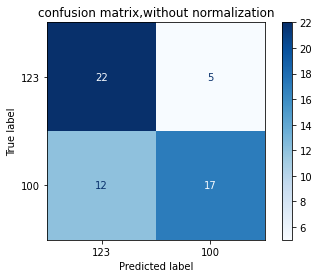

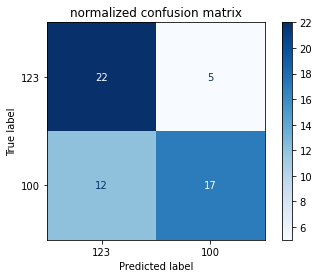

In [15]:
GBC_model,prob,Y_test=upload_classifier(classifier=GradientBoostingClassifier())

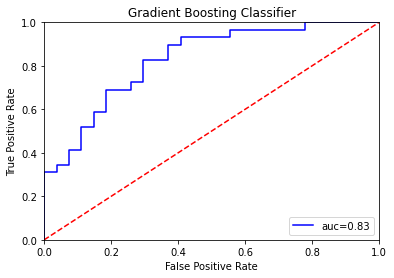

In [16]:
generate_roc_curve(model=GBC_model,Y_test=Y_test,prob=prob,
                   title='Gradient Boosting Classifier')

## Multinomial Naive Bayes

confusion matrix,without normalization
[[26  1]
 [10 19]]
normalized confusion matrix
[[26  1]
 [10 19]]


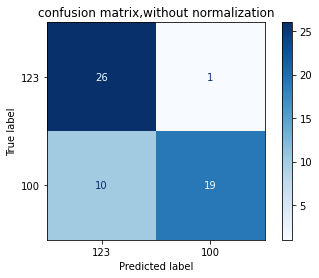

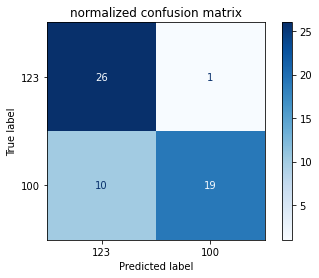

In [17]:
MNB_model,prob,Y_test=upload_classifier(classifier=MultinomialNB())

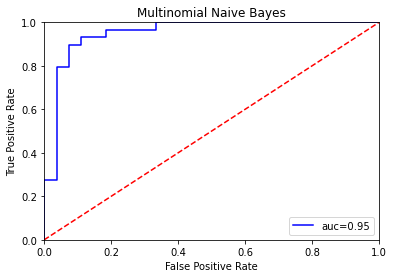

In [18]:
generate_roc_curve(model=MNB_model,Y_test=Y_test,prob=prob,
                   title='Multinomial Naive Bayes')

## Bernoulli Naive Bayes

confusion matrix,without normalization
[[24  3]
 [ 3 26]]
normalized confusion matrix
[[24  3]
 [ 3 26]]


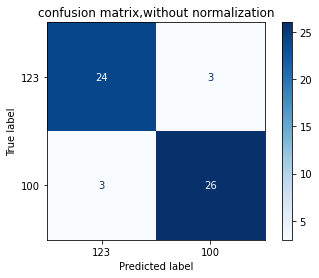

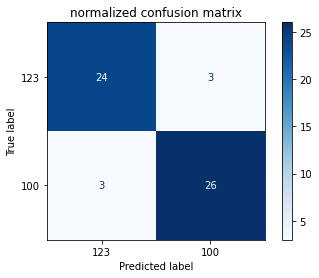

In [19]:
BNB_model,prob,Y_test=upload_classifier(classifier=BernoulliNB())

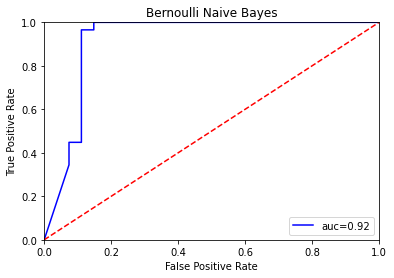

In [20]:
generate_roc_curve(model=BNB_model,Y_test=Y_test,prob=prob,
                   title='Bernoulli Naive Bayes')

## Decision Trees

confusion matrix,without normalization
[[21  6]
 [10 19]]
normalized confusion matrix
[[21  6]
 [10 19]]


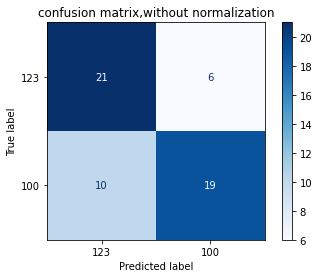

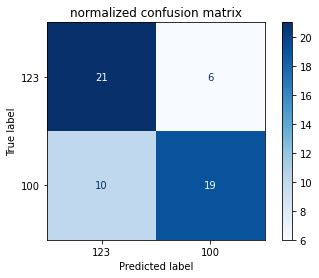

In [21]:
DTs_model,prob,Y_test=upload_classifier(classifier=DecisionTreeClassifier())

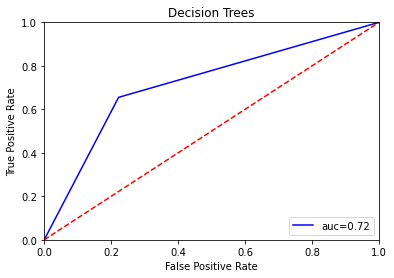

In [22]:
generate_roc_curve(model=DTs_model,Y_test=Y_test,prob=prob,
                   title='Decision Trees')

## Random Forest Classifier

confusion matrix,without normalization
[[27  0]
 [10 19]]
normalized confusion matrix
[[27  0]
 [10 19]]


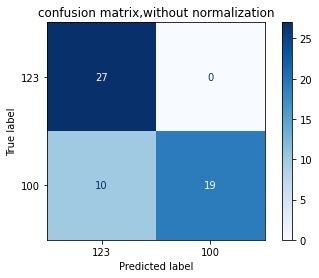

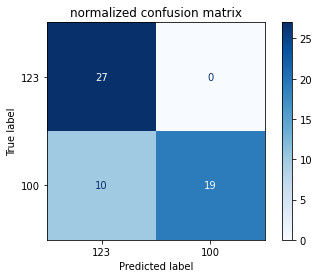

In [23]:
RFC_model,prob,Y_test=upload_classifier(classifier=RandomForestClassifier())

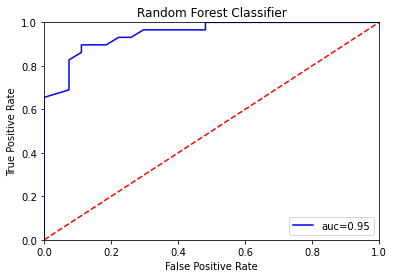

In [24]:
generate_roc_curve(model=RFC_model,Y_test=Y_test,prob=prob,
                   title='Random Forest Classifier')

In [25]:
model_file_list = [r"models/LR_model.pkl", r"models/GBC_model.pkl", 
                   r"models/MNB_model.pkl",r"models/BNB_model.pkl",
                   r"models/DTs_model.pkl", r"models/RFC_model.pkl"]

model_list = [LR_model, GBC_model, MNB_model, BNB_model, DTs_model, RFC_model]

for model, filename in zip(model_list, model_file_list):
    pickle.dump(model, open(filename, 'wb'))

In [26]:
def pre_tokenizer(text, maxword):
    tokenizer = Tokenizer(num_words = maxword)
    tokenizer.fit_on_texts(text)
    with open('tokenizer.pickle','wb') as f:
        pickle.dump(tokenizer, f, protocol = pickle.HIGHEST_PROTOCOL)
pre_tokenizer(df.text, 200)

## Long-short Term Memory

In [27]:
def prepare_testdata(text, tokenizer, Y):
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    print("Vocabulary size: ", len(word_index))
    data = pad_sequences(sequences, padding = 'post', maxlen = 200)
    print("Shape of data tensorflow: ", data.shape)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = Y[indices]
    num_validation_samples = int(0.2*data.shape[0])
    x_train = data[: -num_validation_samples]
    y_train = labels[: -num_validation_samples]
    x_val = data[-num_validation_samples: ]
    y_val = labels[-num_validation_samples: ]
    print("Number of training: ", y_train.sum(axis = 0))
    print("Number of validation: ", y_val.sum(axis = 0))
    print("Number of tokenized sentences:\n", data[0])
    print("Number of one-hot label:\n ", labels[0])
    return x_train, y_train, x_val, y_val
    
def prepare_feature(df, label, text):
    y = df[label].values
    comment_train = df[text]
    comment_train = list(comment_train)
    return comment_train, y

def get_dummies(df, col_label):
    df_y = pd.get_dummies(df[col_label])
    df_new = df.join(df_y)
    df_new = df_new.drop(col_label, axis = 1)
    return df_new

In [28]:
df_label = pd.get_dummies(df.label)
df_label = df_label.reset_index()
df_label = df_label.drop('index', axis = 1)
df_label.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [29]:
df_new = df.join(df_label)
df_new = get_dummies(df = df, col_label = 'label')
df_new.head()

,text,domain,0,1
0,thủ tướng abe cúi đầu lỗi hành động phi thể th...,binhluan.biz,0,1
1,thủ tướng nhật cúi đầu lỗi tinh thần phi thể t...,www.ipick.vn,0,1
2,choáng cơ trưởng đeo khăn quàng quẩy banh sân ...,tintucqpvn.net,0,1
3,chưa bao nhạc kpop hát giáo sư nguyễn lân dũng...,tintucqpvn.net,0,1
4,đại học hutech áp dụng cải tiếq việt học 2018 ...,www.gioitreviet.net,0,1


In [30]:
labels = [0,1]
x_train, y_train = prepare_feature(df = df_new, label = labels, text = 'text')
print(x_train[0], y_train[0])

thủ tướng abe cúi đầu lỗi hành động phi thể thao tuyển nhật theo sankei sports thủ tướng nhật bản shinzo abe công khai gửi lỗi nhật hoàng toàn dân tinh thần thi đấu phi thể thao đội tuyển nhật world cup 2018 tối lượt trận vòng bảng world cup 2018 nhật bản phụ senegal đội thua colombia nhưng nhật bản vòng fair play thẻ phạt thủ tướng nhật bản shinzo abe cúi đầu lỗi với tinh thần võ sĩ đạo samurai đội tuyển nhật bản hành động tinh thần thượng võ thi đấu world cup trích bất bình toàn dân hình ảnh kiên cường dân nhật bản đấu trường quốc tế là đứng đầu thành trách nhiệm gửi lỗi sâu sắc nhân dân abe cúi đầu trách nhiệm người nhật bản nổi tiếng tinh thần trách nhiệm chất võ sĩ đạo đó lý đội tuyển áo xanh mệnh danh samurai xanh tuy nhiên nhật bản trích dội hâm mộ bóng đá lối bóng tiêu cực cố tình câu vé đi tiếp cụ thể phút trận vòng bảng ba lan trận colombia thắng senegal tỷ 1 0 tỉ tương cầu thủ nhật bản hề gỡ hòa các cầu thủ nhật vui vẻ trận thua ba lan 0 1 vé vòng 16 đội tại world cup 2018 f

In [31]:
with open('tokenizer.pickle','rb') as f:
    tokenizer = pickle.load(f)

In [32]:
x_train, y_train, x_test, y_test = prepare_testdata(text = x_train,
                                                    tokenizer = tokenizer, Y = y_train)

Vocabulary size:  4466
Shape of data tensorflow:  (223, 200)
Number of training:  [94 85]
Number of validation:  [29 15]
Number of tokenized sentences:
 [ 41  74  59  68  41  74  61  43 110  98   2  24  99  19  40 120  13  12
 115   7   7  37  56  50   5   5  13  35  95  45  30   3 135 126  70  52
  27   7  13  75  19   3  44 118  68  41  74 129  14  31 133 189  46  52
 199  18 197  53  18 197  65 197  23  46 107  15  82  88 188   2  24  41
  74  72 113  55 147  25  99   2  24  59  46 191 172  97  75  18 197 173
  38  84 195   7  97  75  80  32  46  55  85 199 197  53  97  41  74 149
   7  97  75  25  80  18 197   5  26  13  19 193   7  52  27  70  97   6
 195   5  13  21   8  97  13  60  45  30  72 113  97  62 197  53 191  44
 118   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Number of one-hot label:
  [1 0]


In [33]:
embedding_index = {}
word_index = tokenizer.word_index
embedding_matrix = np.random.random((len(word_index)+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
sequence_input = Input(shape = (200,), dtype = 'int32')
embedding_layer = Embedding(len(word_index)+1, 100, 
                            weights = [embedding_matrix], input_length = 200,
                            trainable = False, name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input);

2022-01-09 16:19:12.928429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-09 16:19:12.928550: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-09 16:19:12.928658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-A03CCO9): /proc/driver/nvidia/version does not exist
2022-01-09 16:19:12.929191: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
x = LSTM(60, return_sequences = True, name = 'LSTM_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
pred = Dense(2, activation = 'sigmoid')(x)

In [36]:
model = Model(sequence_input, pred)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 100)          446700    
                                                                 
 LSTM_layer (LSTM)           (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [37]:
history = model.fit(x_train, y_train, epochs = 20,
                    batch_size = 32, validation_data = (x_test, y_test))

Epoch 1/20
6/6 [==============================] - 4s 224ms/step - loss: 0.7057 - accuracy: 0.4525 - val_loss: 0.6952 - val_accuracy: 0.4773
Epoch 2/20
6/6 [==============================] - 1s 98ms/step - loss: 0.6905 - accuracy: 0.5307 - val_loss: 0.6719 - val_accuracy: 0.6591
Epoch 3/20
6/6 [==============================] - 1s 98ms/step - loss: 0.6953 - accuracy: 0.5251 - val_loss: 0.6705 - val_accuracy: 0.6591
Epoch 4/20
6/6 [==============================] - 1s 97ms/step - loss: 0.6930 - accuracy: 0.5140 - val_loss: 0.6797 - val_accuracy: 0.6591
Epoch 5/20
6/6 [==============================] - 1s 109ms/step - loss: 0.6892 - accuracy: 0.6089 - val_loss: 0.6841 - val_accuracy: 0.6818
Epoch 6/20
6/6 [==============================] - 1s 97ms/step - loss: 0.6853 - accuracy: 0.5698 - val_loss: 0.6595 - val_accuracy: 0.6591
Epoch 7/20
6/6 [==============================] - 1s 102ms/step - loss: 0.6877 - accuracy: 0.5307 - val_loss: 0.6552 - val_accuracy: 0.6591
Epoch 8/20
6/6 [========

In [38]:
model.save(r"models/LSTM_model.h5")

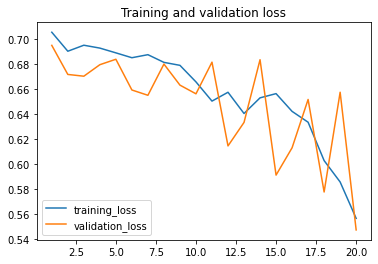

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label = 'training_loss')
plt.plot(epochs, val_loss, label = 'validation_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()